In [206]:
!pip install biosppy
!pip install scipy
!pip install astropy
!pip install heartpy
!pip install hrv-analysis
from hrvanalysis import get_time_domain_features
import heartpy as hp
import pandas as pd
import numpy as np
import math
import pandas
from sklearn.decomposition import FastICA
#from biosppy import storage
#from biosppy.signals import ecg
import matplotlib.pyplot as plt
from sympy import fft
import scipy as sp
from scipy import signal
from scipy.signal import butter, filtfilt, iirnotch, savgol_filter
from astropy.convolution import convolve, Box1DKernel
from scipy import signal

Unfiltered FECG
FECG


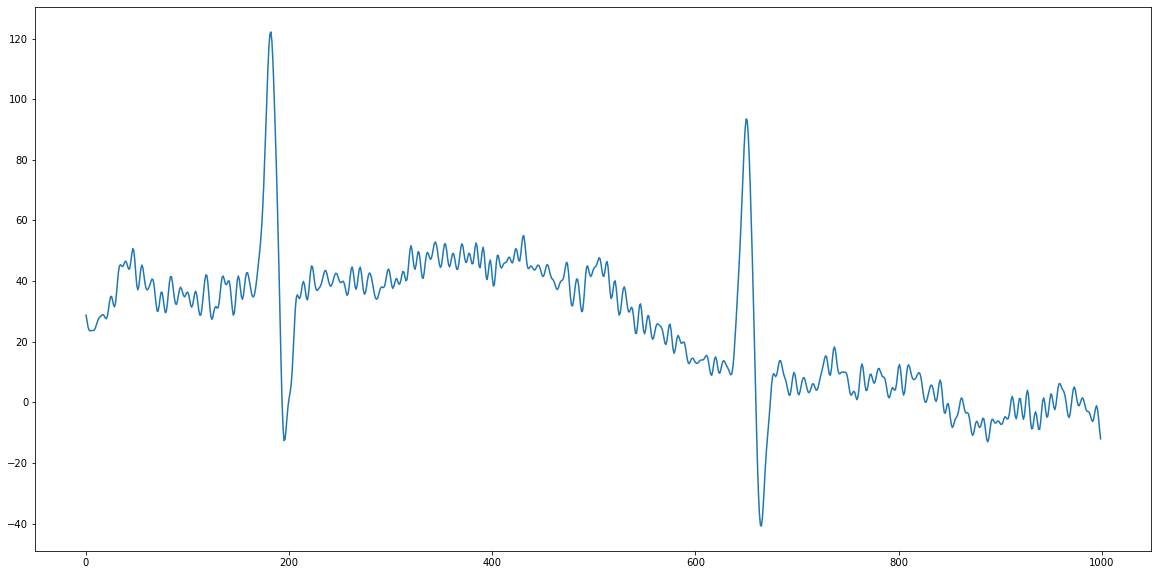

Unfiltered aECGs
aECG1


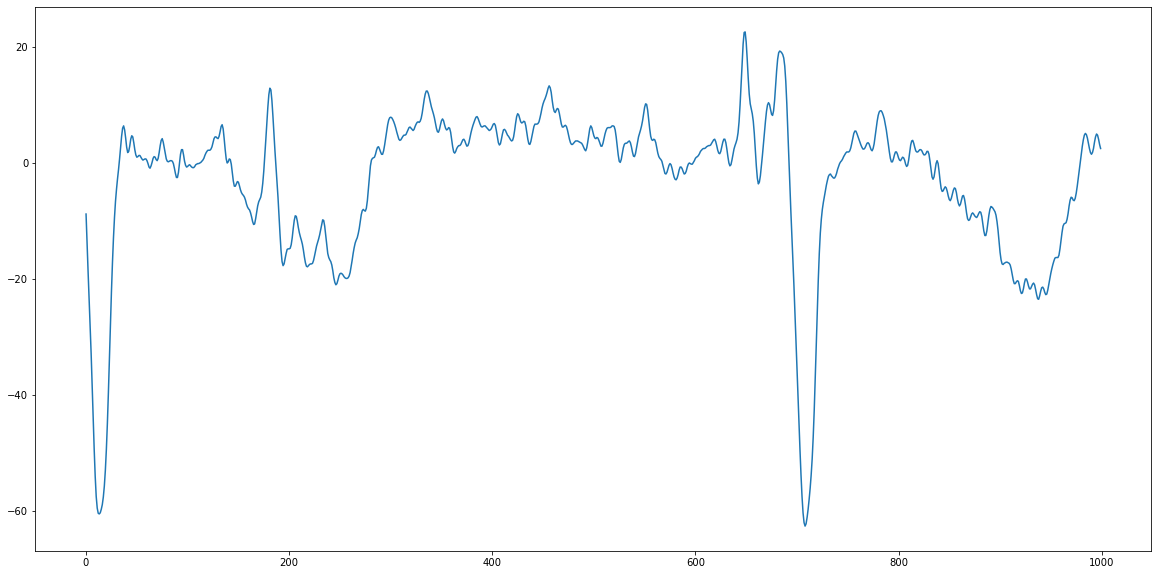

aECG2


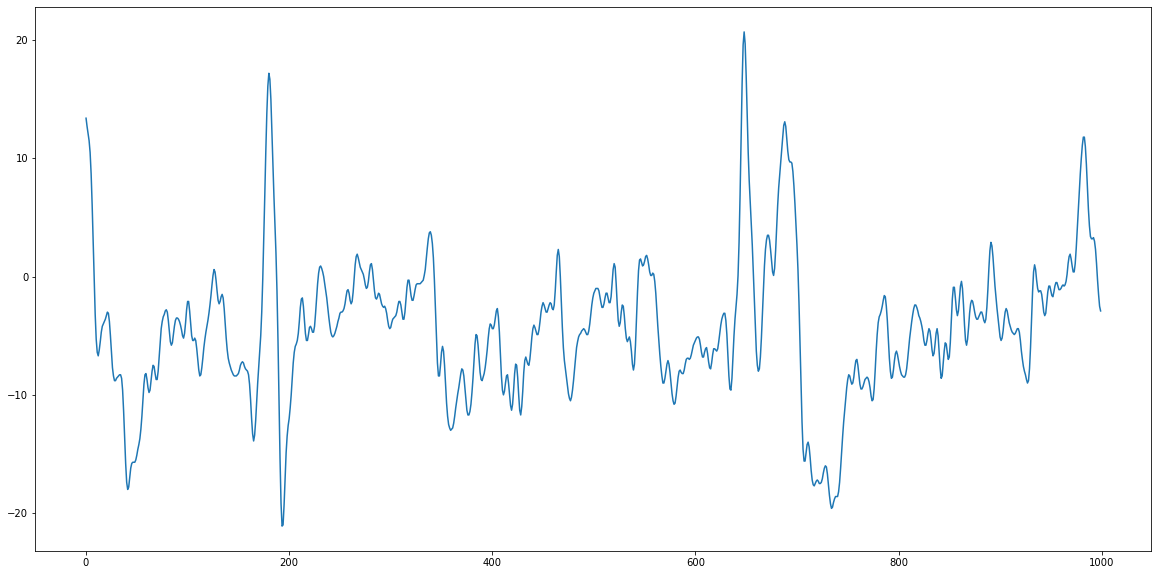

aECG3


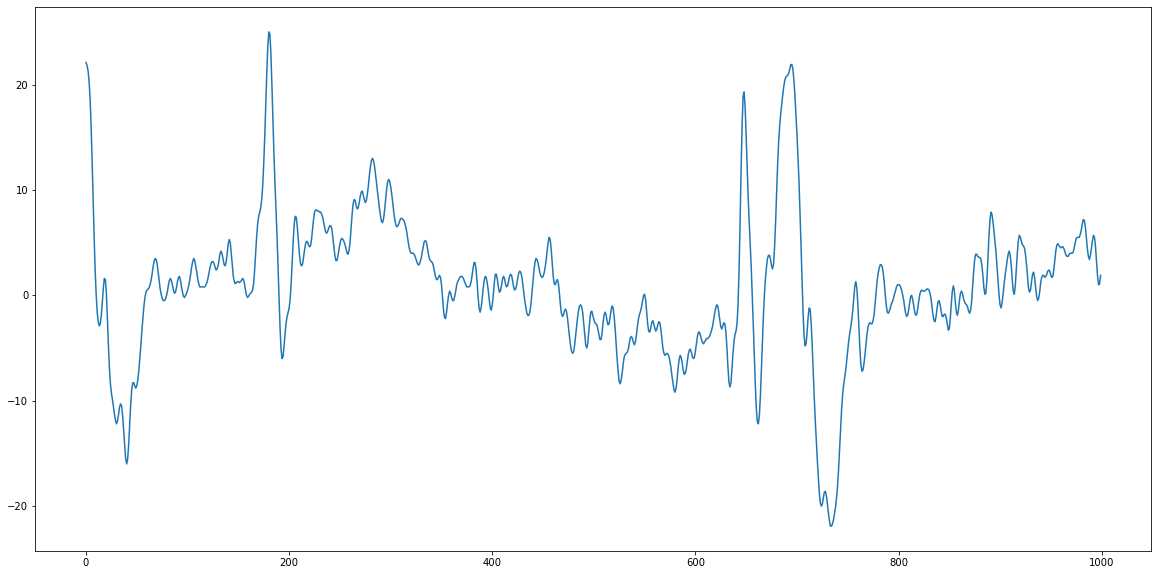

aECG4


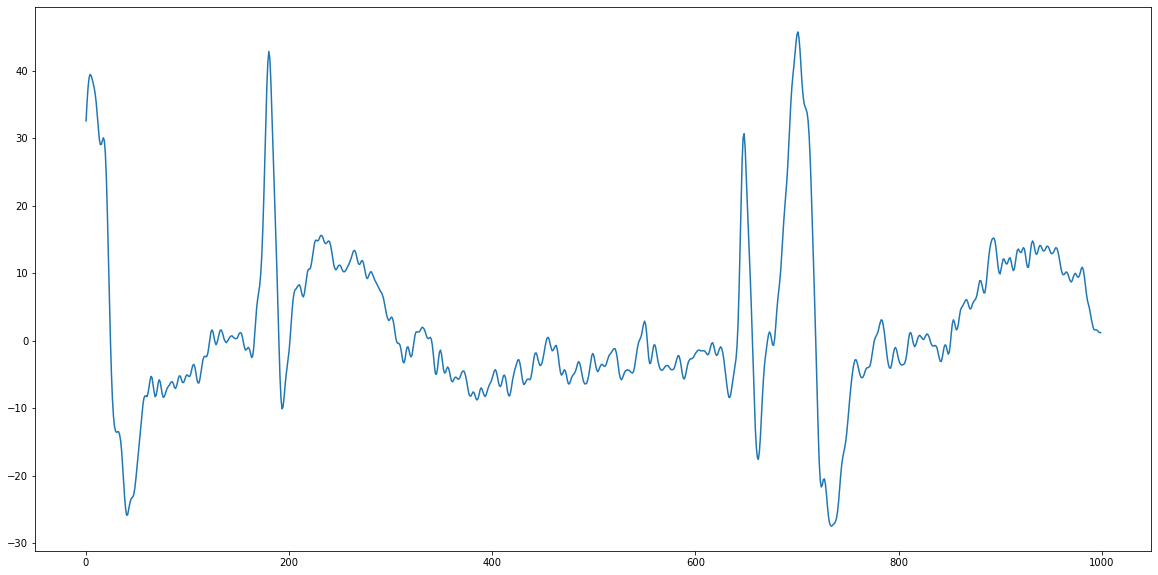

In [207]:
file = pd.read_csv('dataset.csv')
#print(file)

time = file['Elapsed time']
time = np.array(time)[1:].astype('float32')

print('Unfiltered FECG')

data = file['Direct_1']
data = np.array(data)[1:].astype('float32')
#print(data)
plt.figure(figsize=(20,10))
print('FECG')
plt.plot(data[:1000])
plt.show()

print('Unfiltered aECGs')

data1 = file['Abdomen_1']
data1 = np.array(data1)[1:].astype('float32')
#print(data1)
plt.figure(figsize=(20,10))
print('aECG1')
plt.plot(data1[:1000])
plt.show()

data2 = file['Abdomen_2']
data2 = np.array(data2)[1:].astype('float32')
#print(data2)
plt.figure(figsize=(20,10))
print('aECG2')
plt.plot(data2[:1000])
plt.show()

data3 = file['Abdomen_3']
data3 = np.array(data3)[1:].astype('float32')
#print(data3)
plt.figure(figsize=(20,10))
print('aECG3')
plt.plot(data3[:1000])
plt.show()

data4 = file['Abdomen_4']
data4 = np.array(data4)[1:].astype('float32')
#print(data4)
plt.figure(figsize=(20,10))
print('aECG4')
plt.plot(data4[:1000])
plt.show()


In [208]:
def butter_lowpass(cutoff, sample_rate, order=2):
    '''standard lowpass filter.

    Function that defines standard Butterworth lowpass filter

    Parameters
    ----------
    cutoff : int or float
        frequency in Hz that acts as cutoff for filter.
        All frequencies above cutoff are filtered out.

    sample_rate : int or float
        sample rate of the supplied signal

    order : int
        filter order, defines the strength of the roll-off
        around the cutoff frequency. Typically orders above 6
        are not used frequently.
        default: 2
    
    Returns
    -------
    out : tuple
        numerator and denominator (b, a) polynomials
        of the defined Butterworth IIR filter.

    Examples
    --------
    >>> b, a = butter_lowpass(cutoff = 2, sample_rate = 100, order = 2)
    >>> b, a = butter_lowpass(cutoff = 4.5, sample_rate = 12.5, order = 5)
    '''
    nyq = 0.5 * sample_rate
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a


def butter_highpass(cutoff, sample_rate, order=2):
    '''standard highpass filter.

    Function that defines standard Butterworth highpass filter

    Parameters
    ----------
    cutoff : int or float
        frequency in Hz that acts as cutoff for filter.
        All frequencies below cutoff are filtered out.

    sample_rate : int or float
        sample rate of the supplied signal

    order : int
        filter order, defines the strength of the roll-off
        around the cutoff frequency. Typically orders above 6
        are not used frequently.
        default : 2
    
    Returns
    -------
    out : tuple
        numerator and denominator (b, a) polynomials
        of the defined Butterworth IIR filter.

    Examples
    --------
    we can specify the cutoff and sample_rate as ints or floats.

    >>> b, a = butter_highpass(cutoff = 2, sample_rate = 100, order = 2)
    >>> b, a = butter_highpass(cutoff = 4.5, sample_rate = 12.5, order = 5)
    '''
    nyq = 0.5 * sample_rate
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

In [209]:
measures = {}

def rolmean(dataset, hrw, fs):
    mov_avg = dataset['hart'].rolling(int(hrw*fs)).mean()
    avg_hr = (np.mean(dataset.hart))
    mov_avg = [avg_hr if math.isnan(x) else x for x in mov_avg]
    mov_avg = [x*1.2 for x in mov_avg]
    dataset['hart_rollingmean'] = mov_avg

def detect_peaks(dataset):
    window = []
    peaklist = []
    listpos = 0
    for datapoint in dataset.hart:
        rollingmean = dataset.hart_rollingmean[listpos]
        if (datapoint < rollingmean) and (len(window) < 1):
            listpos += 1
        elif (datapoint > rollingmean):
            window.append(datapoint)
            listpos += 1
        else:
            maximum = max(window)
            beatposition = listpos - len(window) + (window.index(max(window)))
            peaklist.append(beatposition)
            window = []
            listpos += 1
    measures['peaklist'] = peaklist
    measures['ybeat'] = [dataset.hart[x] for x in peaklist]

def calc_RR(dataset, fs):
    RR_list = []
    peaklist = measures['peaklist']
    cnt = 0
    while (cnt < (len(peaklist)-1)):
        RR_interval = (peaklist[cnt+1] - peaklist[cnt])
        ms_dist = ((RR_interval / fs) * 1000.0)
        RR_list.append(ms_dist)
        cnt += 1
    measures['RR_list'] = RR_list

def calc_bpm():
    RR_list = measures['RR_list']
    measures['bpm'] = 20000 / np.mean(RR_list)

def plotter(dataset, title):
    peaklist = measures['peaklist']
    print(peaklist)
    ybeat = measures['ybeat']
    print(ybeat)
    plt.title(title)
    plt.plot(time, dataset.hart, alpha=0.5, color='blue', label="raw signal")
    plt.plot(time, dataset.hart_rollingmean, color ='green', label="moving average")
    plt.scatter(peaklist, ybeat, color='red', label="average: %.1f BPM" %measures['bpm'])
    plt.legend(loc=4, framealpha=0.6)
    plt.show()

def process(dataset, hrw, fs): #Remember; hrw was the one-sided window size (we used 0.75) and fs was the sample rate (file is recorded at 100Hz)
    rolmean(dataset, hrw, fs)
    detect_peaks(dataset)
    calc_RR(dataset, fs)
    calc_bpm()
    plotter(dataset, "My Heartbeat Plot")

# FECG HR Calculation

Unfiltered FECG


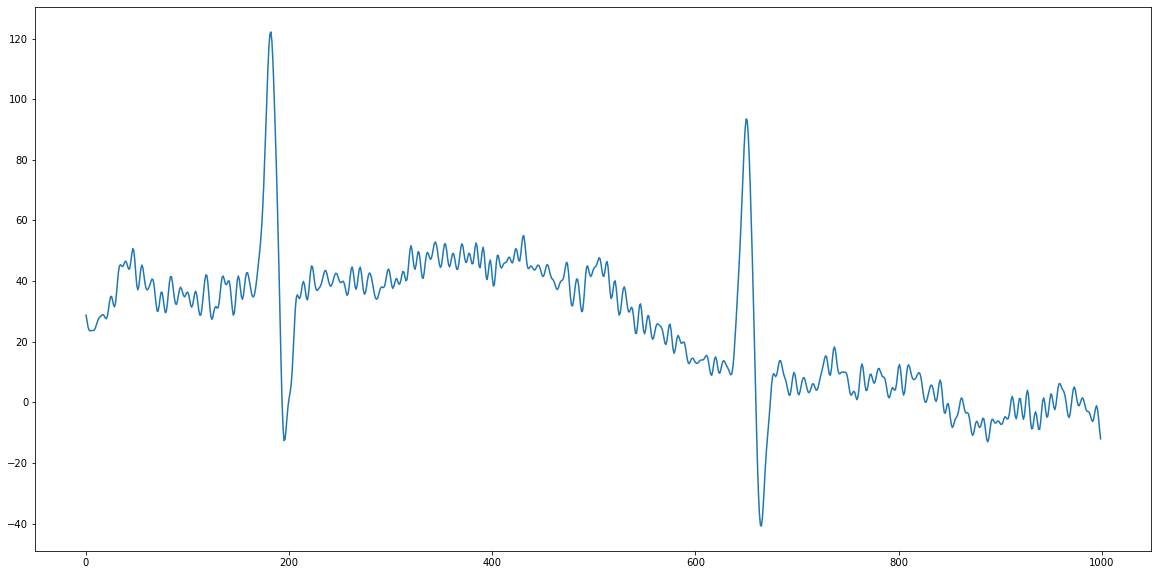

Lowpassed at 15 Hz - FECG
Filtered FECG


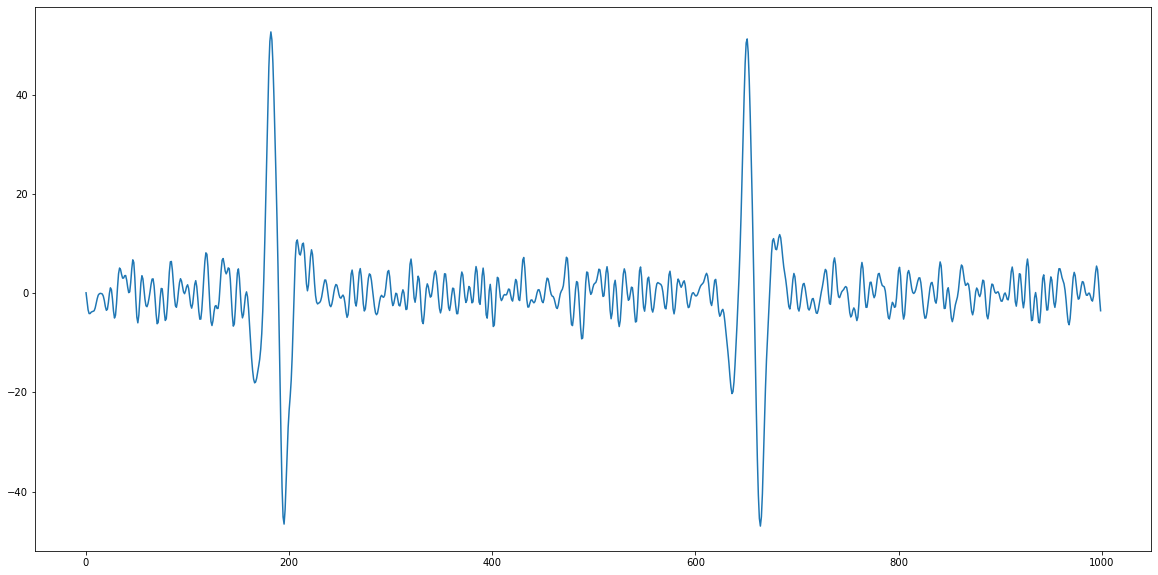

Highpassed at 5 Hz - FECG


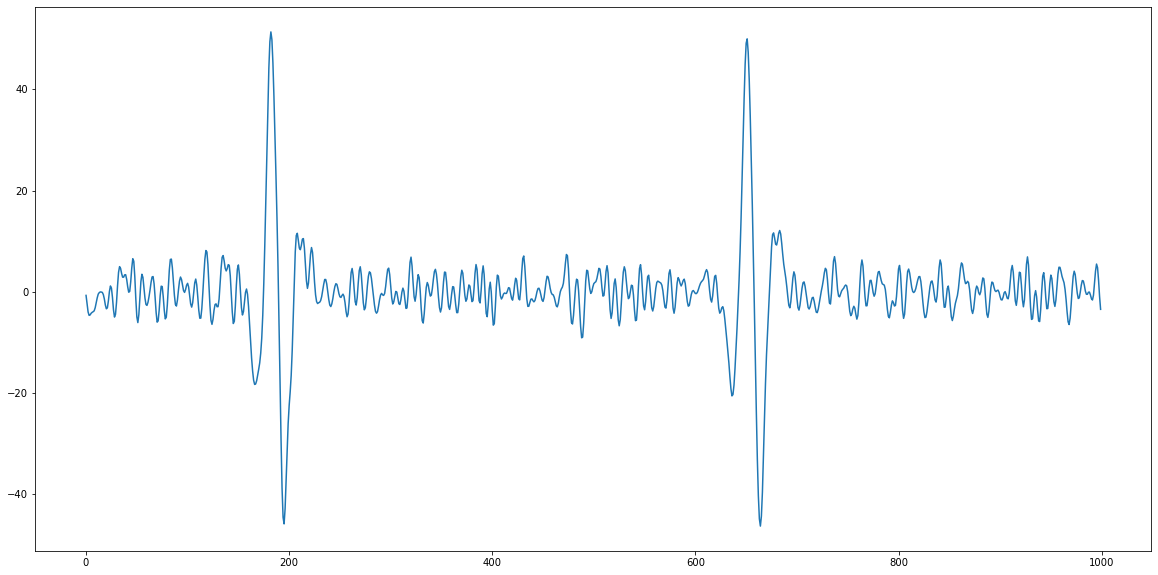

Differentiated FECG


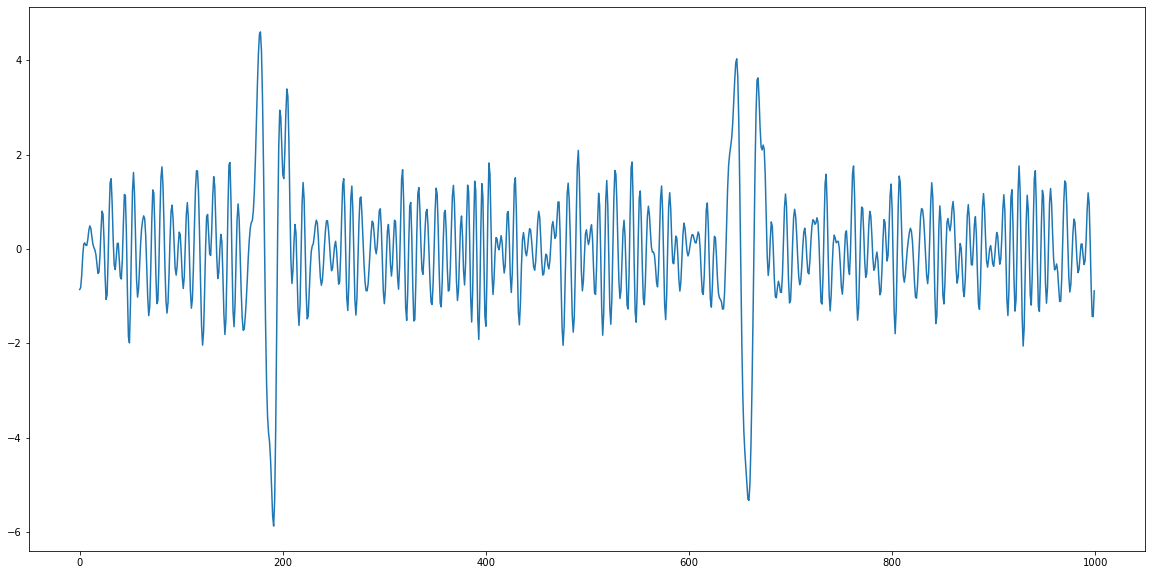

squared FECG


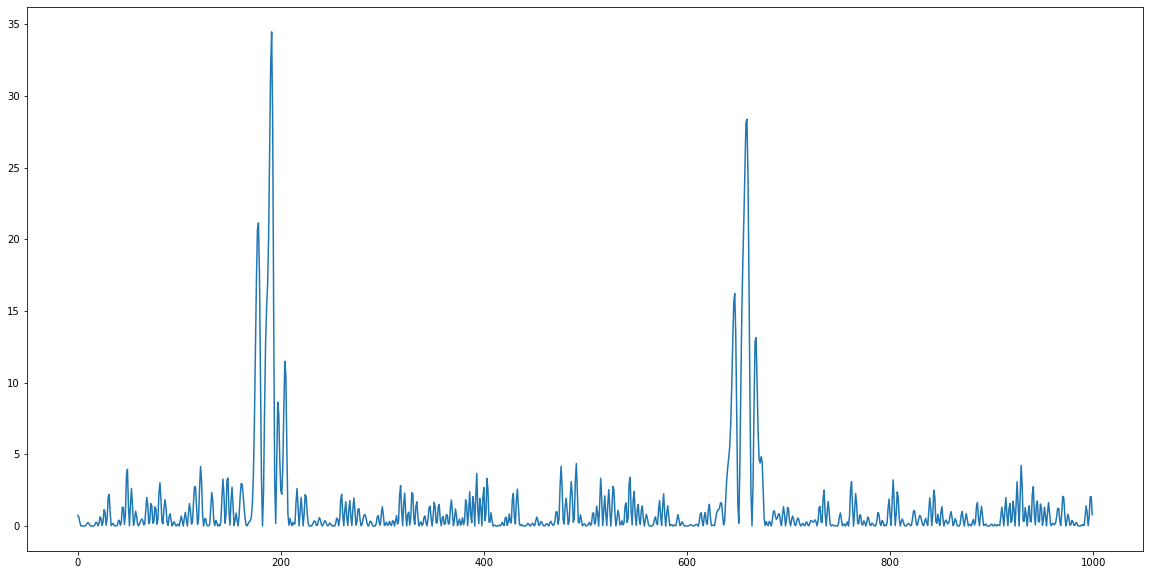

smooth FECG


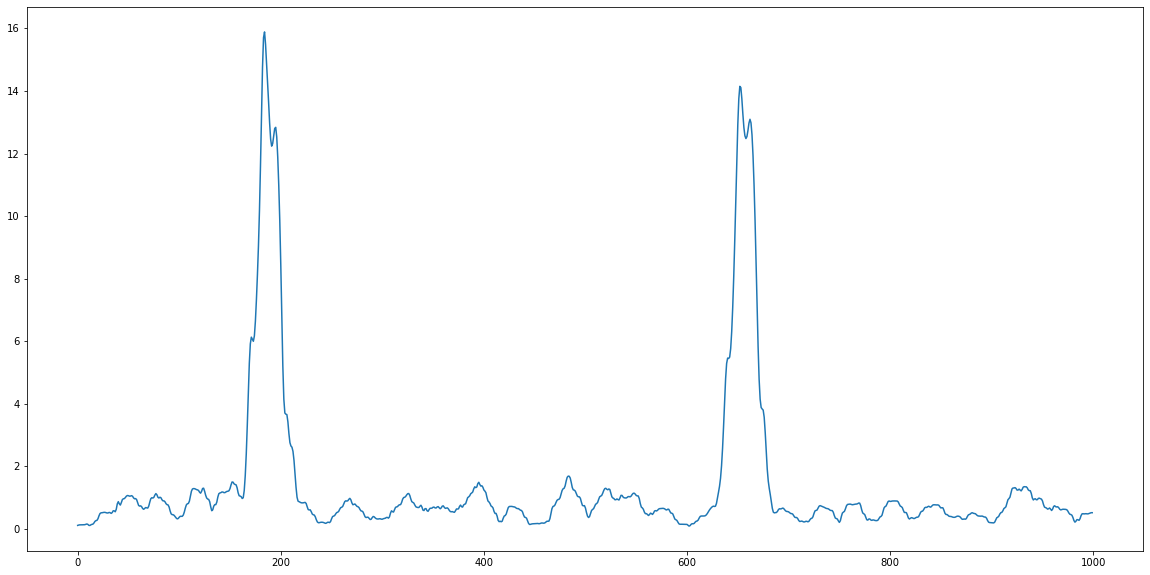

In [233]:
lowpass = signal.filtfilt(b, a, data)
b, a = butter_highpass(5, 500)
highpass = signal.filtfilt(b, a, lowpass)
derivate_signal = np.gradient(highpass, 2)
squared = np.square(derivate_signal)
smooth = convolve(squared,kernel=Box1DKernel(20))

print('Unfiltered FECG')
plt.figure(figsize=(20,10))
plt.plot(data[:1000])
plt.show()

print('Lowpassed at 15 Hz - FECG')
print('Filtered FECG')
plt.figure(figsize=(20,10))
plt.plot(lowpass[:1000])
plt.show()

print('Highpassed at 5 Hz - FECG')
plt.figure(figsize=(20,10))
plt.plot(highpass[:1000])
plt.show()

print('Differentiated FECG')
plt.figure(figsize=(20,10))
plt.plot(derivate_signal[:1000])
plt.show()

print('squared FECG')
plt.figure(figsize=(20,10))
plt.plot(squared[:1000])
plt.show()

print('smooth FECG')
plt.figure(figsize=(20,10))
plt.plot(smooth[:1000])
plt.show()

[5, 10, 22, 31, 37, 44, 53, 63, 72, 81, 91, 98, 106, 115, 126, 132, 139, 148, 156, 177, 204, 212, 220, 233, 244, 252, 260, 268, 277, 288, 296, 304, 310, 318, 326, 334, 342, 351, 360, 368, 376, 382, 389, 396, 403, 415, 422, 429, 437, 443, 452, 471, 481, 491, 504, 511, 519, 527, 536, 544, 552, 560, 573, 581, 587, 595, 603, 609, 618, 626, 646, 668, 681, 695, 704, 714, 726, 735, 743, 755, 762, 770, 778, 792, 799, 807, 818, 829, 839, 847, 860, 867, 875, 882, 890, 897, 903, 910, 918, 925, 933, 941, 948, 956, 970, 979, 987, 993, 1006, 1020, 1029, 1038, 1044, 1051, 1063, 1071, 1078, 1086, 1093, 1110, 1135, 1163, 1172, 1183, 1191, 1198, 1204, 1218, 1228, 1237, 1249, 1257, 1266, 1274, 1282, 1291, 1297, 1305, 1311, 1320, 1336, 1344, 1352, 1364, 1372, 1384, 1396, 1405, 1414, 1421, 1428, 1436, 1442, 1456, 1465, 1472, 1479, 1486, 1498, 1508, 1521, 1535, 1543, 1553, 1563, 1578, 1603, 1613, 1622, 1631, 1642, 1654, 1662, 1668, 1675, 1683, 1690, 1698, 1709, 1717, 1728, 1741, 1755, 1762, 1770, 1777, 1790

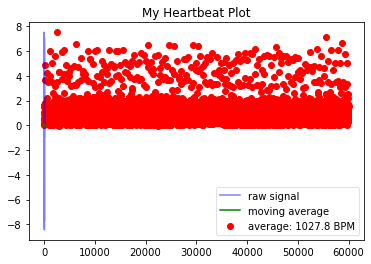

1027.8208397926358


In [211]:
FHR = pd.DataFrame(derivate_signal)
FHR['hart'] = FHR[0]
process(FHR, 0.75, 500)
FHR_Value = measures['bpm']
print(FHR_Value)

Band-filtered aECG
aECG1


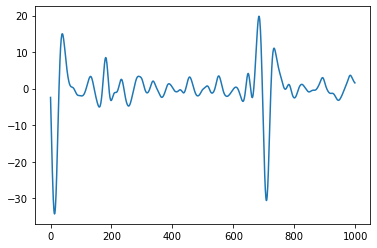

aECG2


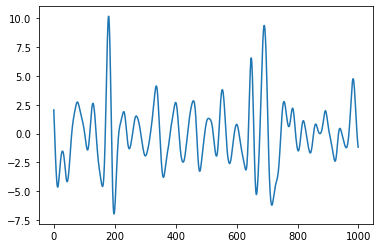

aECG3


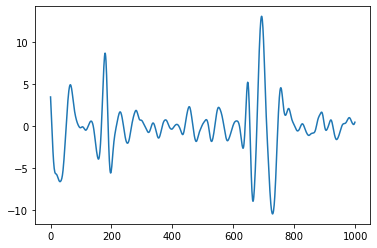

aECG4


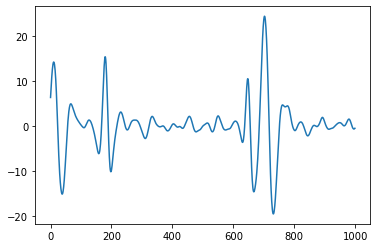

In [71]:
# b, a = butter_lowpass(15, 500)
# lowpass1 = signal.filtfilt(b, a, data1)
# b, a = butter_highpass(5, 500)
# highpass1 = signal.filtfilt(b, a, lowpass1)
# print('Band-filtered aECG')
# print('aECG1')
# plt.plot(highpass1[:1000])
# plt.show()

# b, a = butter_lowpass(15, 500)
# lowpass2 = signal.filtfilt(b, a, data2)
# b, a = butter_highpass(5, 500)
# highpass2 = signal.filtfilt(b, a, lowpass2)
# print('aECG2')
# plt.plot(highpass2[:1000])
# plt.show()

# b, a = butter_lowpass(15, 500)
# lowpass3 = signal.filtfilt(b, a, data3)
# b, a = butter_highpass(5, 500)
# highpass3 = signal.filtfilt(b, a, lowpass3)
# print('aECG3')
# plt.plot(highpass3[:1000])
# plt.show()

# b, a = butter_lowpass(15, 500)
# lowpass4 = signal.filtfilt(b, a, data4)
# b, a = butter_highpass(5, 500)
# highpass4 = signal.filtfilt(b, a, lowpass4)
# print('aECG4')
# plt.plot(highpass4[:1000])
# plt.show()

# aECG filtering, decomposition, R-peak matching, and HR calculation

In [212]:
def create_data(split=0.2, n=60000):
    data = []
    df = pandas.read_csv('dataset.csv')
    df_np = np.array(df)[1:n+1, 1:6].astype('float32')
    X = df_np[:, 1:]
    y = df_np[:, 0]
    return X, y
    
x_train, y_train = create_data()
print(x_train)
print(y_train)

[[ -8.8    13.4    22.1    32.6  ]
 [-13.9    12.7    21.8    35.401]
 [-18.7    12.1    21.3    37.601]
 ...
 [-41.301  -0.6     7.4    25.9  ]
 [-41.701  -1.3     7.1    25.9  ]
 [-42.401  -1.8     6.5    26.   ]]
[28.8 26.7 24.8 ... 13.2 14.6 13. ]


In [213]:
transformer = FastICA(random_state=0)
X_transformed = transformer.fit_transform(x_train)

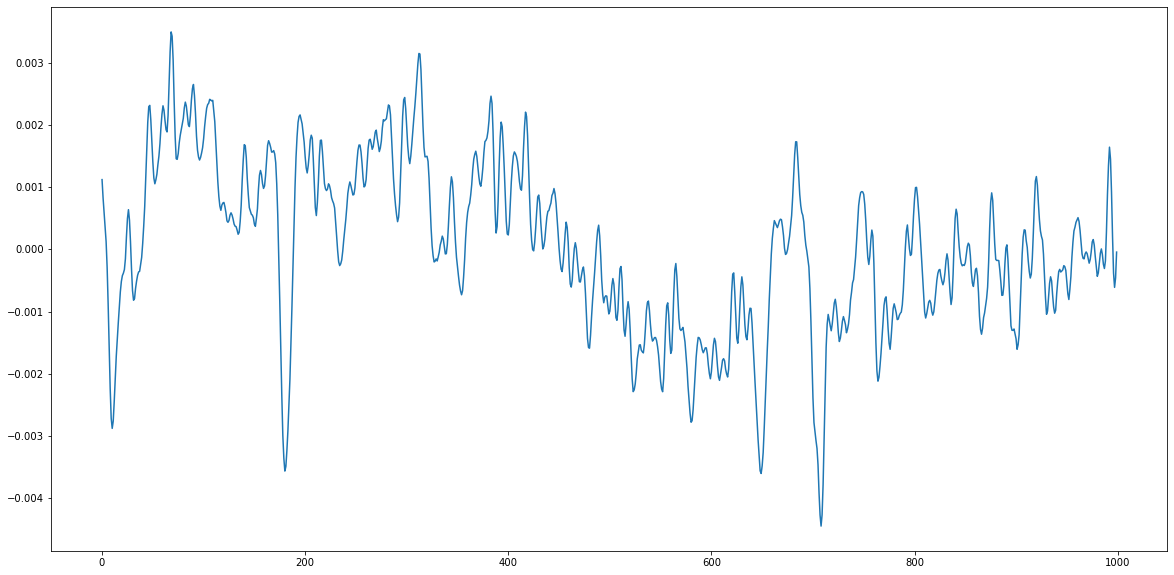

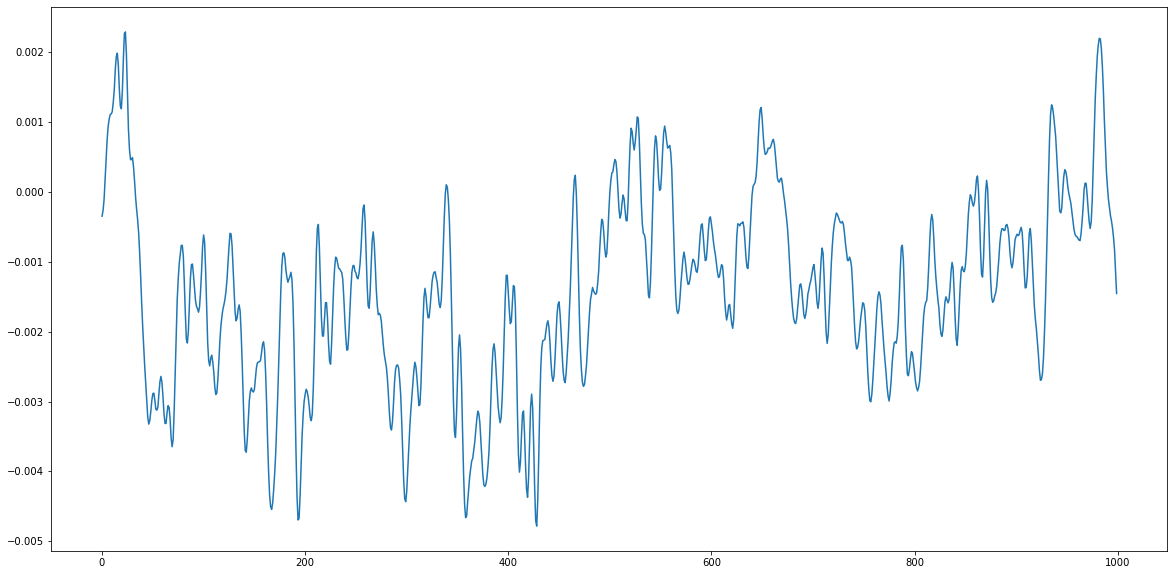

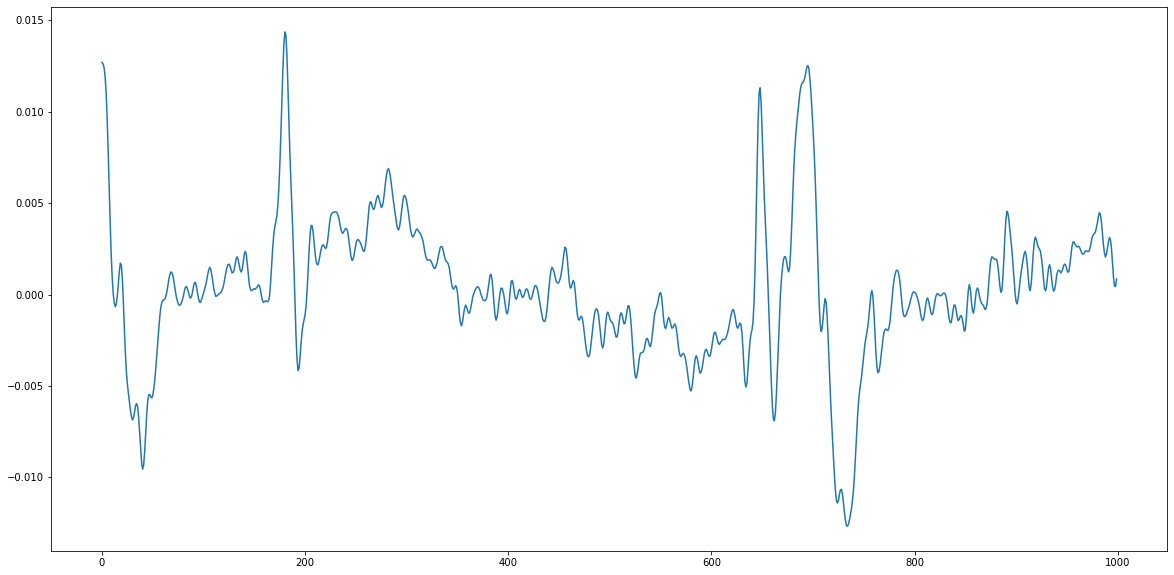

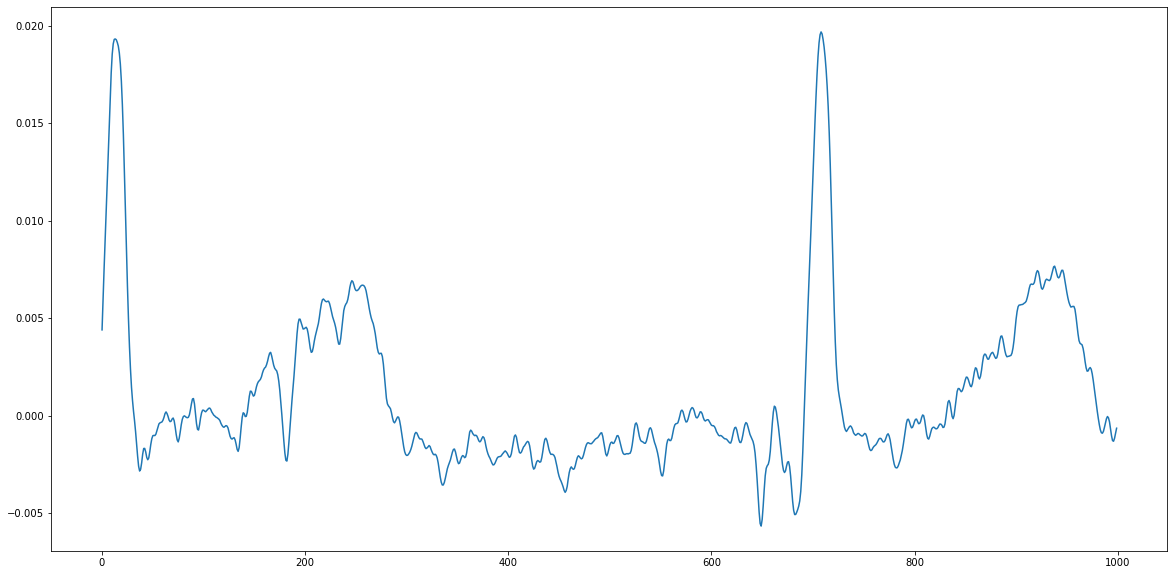

In [240]:
plt.figure(figsize=(20,10))
plt.plot(X_transformed[:1000, 0])
plt.figure(figsize=(20,10))
plt.plot(X_transformed[:1000, 1])
plt.figure(figsize=(20,10))
plt.plot(X_transformed[:1000, 2])
plt.figure(figsize=(20,10))
plt.plot(X_transformed[:1000, 3])

# Signal Matching - Selecting the best ICA Output

In [262]:
highpass = highpass  ##filtered fetal ecg

##comparison of indices for R-peaks between fetal ecg and all ICA outputs to calculate the best output
import numpy as np
import matplotlib.pyplot as plt

#mse = np.ndarray((len(highpass) - len(X_transformed[:,1]) + 1))

#for i in range(len(highpass) - len(X_transformed[:,1]) + 1):
#    mse[i] = np.square(np.subtract(highpass[i:i+len(X_transformed[:,1])],X_transformed[:,1])).mean()

#print(mse.argmin())
#plt.plot(mse)

# sum = 0
# for i in y_train[0][:1000]:
#     for j in X_transformed[:1000,3]:
#         sum = sum + i*j
# print(sum)

cor = []
for i in range(4):
    correlations = np.correlate(highpass, X_transformed[:,i], mode = "full")
    cor.append(sum(correlations))
    #plt.plot(correlations)
index_max = max(range(len(cor)), key=cor.__getitem__)

best = X_transformed[:1000, index_max]  #storing the most similar ICA ouptut as compared to FECG

# Filtering and Peak Matching

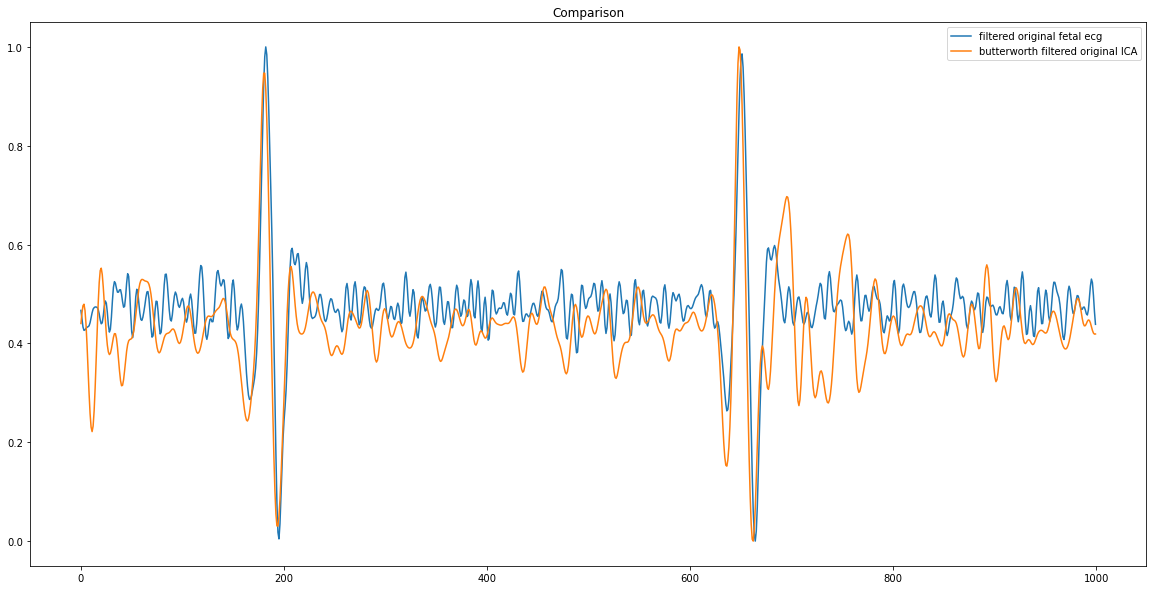

In [263]:
b, a = butter_lowpass(35, 500)         #filtering the best ICA output
lowpass4 = signal.filtfilt(b, a, best)
b, a = butter_highpass(10, 500)
highpass4 = signal.filtfilt(b, a, lowpass4)
highpass4 = (highpass4+(-1*np.min(highpass4)))
highpass4 = highpass4/np.max(highpass4)

# sos = signal.butter(10, 35, fs=500, output='sos')
# filtered = signal.sosfilt(sos, X_transformed[:1000, 2])
# fil = (filtered+(-1*np.min(filtered)))
# fil = fil/np.max(fil)

# output4 = (X_transformed[:1000, 2]+(-1*np.min(X_transformed[:1000, 2])))
# output4 = output4/np.max(output4)

# yt0 = (y_train[:1000]+(-1*np.min(y_train[:1000])))
# yt0 = yt0/np.max(yt0)

highpass = (highpass[:1000]+(-1*np.min(highpass[:1000]))) #filtered FECG
highpass = highpass/np.max(highpass)

plt.figure(figsize=(20,10))
plt.plot(highpass[:1000])
plt.plot(highpass4)
plt.title("Comparison")
plt.legend(['filtered original fetal ecg', 'butterworth filtered original ICA'])

# Heart rate Calculation

[20, 60, 180, 207, 648, 695, 755, 782, 892]
[0.5522616498588783, 0.5295756645792682, 0.9469780249559598, 0.5555254411721122, 1.0, 0.6970731115044786, 0.6212908388121189, 0.5305158370004991, 0.5590218613104042]


ValueError: x and y must have same first dimension, but have shapes (60000,) and (1000,)

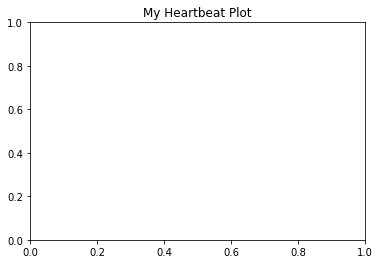

In [219]:
#Method 1:
import statistics
plt.figure(figsize=(20,10))
plt.plot(time[:1000], smooth[:1000])
last = 0
upflag = 0
pulse = np.zeros(len(smooth))
pulse2 = []
print(len(time))
for i in range(len(smooth)):
    if smooth[i] > 0.000100:
        if upflag == 0:
            if last > 0:
                t = time[i] - time[last]
                p = (t/500)*20000
                pulse[i] = p
                pulse2.append(p)
            last = i
            upflag = 50
        else:
            if (upflag > 0):
                upflag = upflag - 1
#print(pulse[1600:2000])
print(statistics.mean(pulse2))
#plt.plot(pulse)

#Method 3:
import statistics
plt.figure(figsize=(20,10))
plt.plot(time[:1000], smooth[:1000])
peak_lst = []
HR_lst1 = []
HR_lst2 = []
for i in range(len(smooth)-1):
    current_value = smooth[i]
    next_value = smooth[i+1]
    if (next_value < current_value):
        peak_lst.append(current_value)
for j in range(len(peak_lst)-1):
    index1 = np.where(smooth == peak_lst[j])
    index2 = np.where(smooth == peak_lst[j+1])
    time1 = time[index1]
    time2 = time[index2]
    time_dif = abs(time2 - time1)
    HR = (20000*500)/time_dif
    HR_lst1.append(HR)
    HR2 = (time_dif/500)*20000
    HR_lst2.append(HR2)
print(statistics.mean(HR2)*1000)